In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import layers
from keras import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
df = shuffle(df)
df_nadropped = df.dropna()

In [3]:
df_nadropped.shape

(2140, 31)

In [4]:
def process_data(df):
    images = df['Image'].apply(lambda im_str: np.array([float(x)/255 for x in im_str.split()]))
    labels = df.drop('Image', 1)
    return np.array(images.values.tolist()), labels.values

In [5]:
train_features, train_labels = process_data(df_nadropped[800:])
validation_features, validation_labels = process_data(df_nadropped[:800])

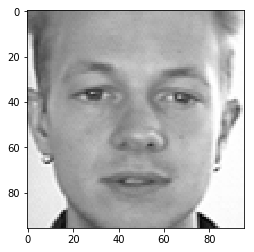

In [6]:
plt.imshow(train_features[8].reshape((96,96)), cmap='gray')

train an MLP model for flatterned images

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 00132: early stopping


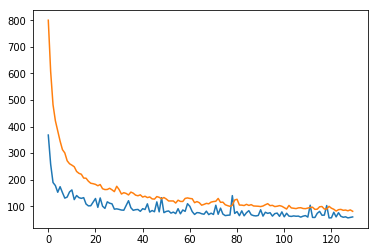

In [7]:
model_mlp = Sequential()
model_mlp.add(layers.Dense(128, activation = 'relu', input_shape=(9216,)))
model_mlp.add(layers.Dropout(0.20))
model_mlp.add(layers.Dense(32, activation = 'relu'))
model_mlp.add(layers.Dropout(0.20))
model_mlp.add(layers.Dense(30, activation = 'linear'))

model_mlp.compile(optimizer=optimizers.Adam(0.001), 
              loss = 'mean_squared_error',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history = model_mlp.fit(train_features, 
                    train_labels, 
                    epochs = 200, 
                    verbose= 0, 
                    batch_size= 100, 
                    validation_data=(validation_features, validation_labels),
                    callbacks=[es])

# evaluate result
plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['loss'][2:])

In [8]:
validation_predicted_labels = model_mlp.predict(validation_features)

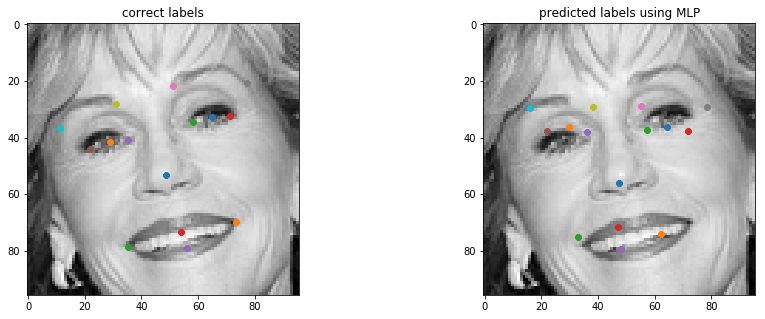

In [9]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].imshow(validation_features[1].reshape((96,96)), cmap='gray')
ax[0].plot([validation_labels[1][0::2]],[validation_labels[1][1::2]], marker='8')
ax[0].title.set_text('correct labels')
ax[1].imshow(validation_features[1].reshape((96,96)), cmap='gray')
ax[1].plot([validation_predicted_labels[1][0::2]],
           [validation_predicted_labels[1][1::2]], marker='8')
ax[1].title.set_text('predicted labels using MLP')

train a CNN model

In [10]:
train_features, train_labels = process_data(df_nadropped[800:])
validation_features, validation_labels = process_data(df_nadropped[:800])

train_features_reshaped = train_features.reshape(train_features.shape[0],96,96,1)
validation_features_reshaped = validation_features.reshape(validation_features.shape[0],96,96,1)

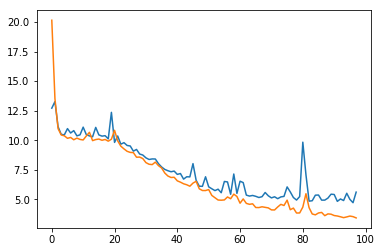

In [11]:
# train a CNN

model_cnn = Sequential()
model_cnn.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(96,96,1)))
model_cnn.add(Conv2D(32, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(30, activation='linear'))

model_cnn.compile(optimizer=optimizers.Adam(0.005), 
              loss = 'mean_squared_error',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history = model_cnn.fit(train_features_reshaped, 
                    train_labels, 
                    epochs = 100,
                    verbose= 0, 
                    batch_size= 100, 
                    validation_data=(validation_features_reshaped, validation_labels),
                    callbacks=[es])

# evaluate result
plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['loss'][2:])

In [12]:
validation_predicted_labels_cnn = model_cnn.predict(validation_features_reshaped)

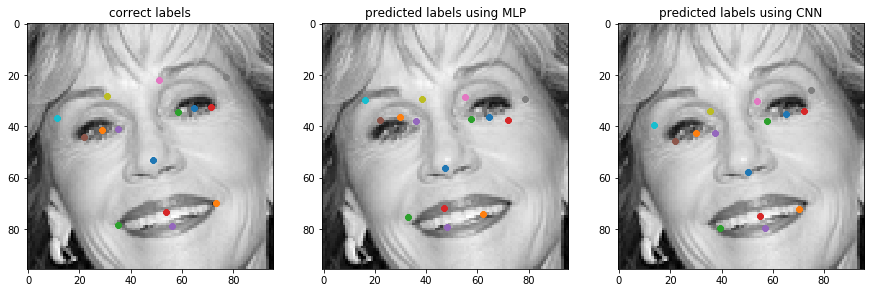

In [13]:
fig, ax = plt.subplots(1,3, figsize = (15, 10))

ax[0].imshow(validation_features[1].reshape((96,96)), cmap='gray')
ax[0].plot([validation_labels[1][0::2]],[validation_labels[1][1::2]], marker='8')
ax[0].title.set_text('correct labels')
ax[1].imshow(validation_features[1].reshape((96,96)), cmap='gray')
ax[1].plot([validation_predicted_labels[1][0::2]],
           [validation_predicted_labels[1][1::2]], marker='8')
ax[1].title.set_text('predicted labels using MLP')
ax[2].imshow(validation_features[1].reshape((96,96)), cmap='gray')
ax[2].plot([validation_predicted_labels_cnn[1][0::2]],
           [validation_predicted_labels_cnn[1][1::2]], marker='8')
ax[2].title.set_text('predicted labels using CNN')

Use existing features to predict missing features

In [14]:
df_feature_group_1 = df_nadropped[['left_eye_center_x','left_eye_center_y','right_eye_center_x',
                                   'right_eye_center_y','nose_tip_x','nose_tip_y',
                                   'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']]
df_feature_group_2 = df_nadropped.drop(['left_eye_center_x','left_eye_center_y','right_eye_center_x',
                                        'right_eye_center_y','nose_tip_x','nose_tip_y',
                                        'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y',
                                        'Image'], 1)

train_features = df_feature_group_1[800:]
train_labels = df_feature_group_2[800:]

validation_features = df_feature_group_1[:800]
validation_labels = df_feature_group_2[:800]

Epoch 00026: early stopping


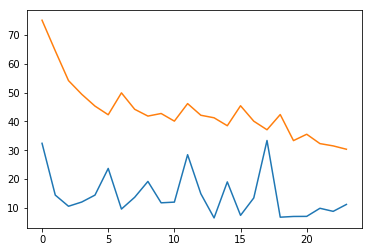

In [15]:
# train a linear model to estimate missing features
model_missing_features = Sequential()

model_missing_features.add(Dense(32, activation ='linear', input_shape=(8,)))
model_missing_features.add(layers.Dropout(0.20))
model_missing_features.add(Dense(22, activation='linear'))

model_missing_features.compile(optimizer=optimizers.Adam(0.03), 
              loss = 'mean_squared_error',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history = model_missing_features.fit(train_features, 
                    train_labels, 
                    epochs = 100,
                    verbose= 0, 
                    batch_size= 100, 
                    validation_data=(validation_features, validation_labels),
                    callbacks=[es])

plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['loss'][2:])

In [30]:
# two feature groups
feature_col_group1 = ['left_eye_center_x','left_eye_center_y',
                  'right_eye_center_x','right_eye_center_y',
                  'nose_tip_x','nose_tip_y', 
                  'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
feature_col_group2 = [x for x in df_nadropped.columns.values if x not in feature_col_group1]
feature_col_group2.remove('Image')

df_selected_labels = df[feature_col_group1+['Image']]
df_selected_labels_nadropped = df_selected_labels.dropna()

df_selected = df[df.index.isin(df_selected_labels_nadropped.index)].copy()

# fill missing values
for i in df_selected.index:
    if df_selected.loc[i,feature_col_group2].isnull().values.any():
        df_selected.loc[i,feature_col_group2] = model_missing_features.predict(
            df_selected.loc[i,feature_col_group1].values.reshape((1,8))).flatten()
        
train_features, train_labels = process_data(df_selected[800:])
validation_features, validation_labels = process_data(df_selected[:800])

train_features_reshaped = train_features.reshape(train_features.shape[0],96,96,1)
validation_features_reshaped = validation_features.reshape(validation_features.shape[0],96,96,1)

Train on 6200 samples, validate on 800 samples
Epoch 1/30
6200/6200 [==============================] - 248s 40ms/step - loss: 163.6891 - mean_absolute_error: 7.4743 - val_loss: 9.8243 - val_mean_absolute_error: 2.1302
Epoch 2/30
6200/6200 [==============================] - 230s 37ms/step - loss: 10.4196 - mean_absolute_error: 2.1696 - val_loss: 9.7790 - val_mean_absolute_error: 2.1083
Epoch 3/30
6200/6200 [==============================] - 231s 37ms/step - loss: 10.0852 - mean_absolute_error: 2.1269 - val_loss: 9.6939 - val_mean_absolute_error: 2.1665
Epoch 4/30
6200/6200 [==============================] - 232s 37ms/step - loss: 10.0811 - mean_absolute_error: 2.1340 - val_loss: 8.8102 - val_mean_absolute_error: 1.9941
Epoch 5/30
6200/6200 [==============================] - 233s 38ms/step - loss: 9.3947 - mean_absolute_error: 2.0377 - val_loss: 8.1509 - val_mean_absolute_error: 1.8998
Epoch 6/30
6200/6200 [==============================] - 232s 37ms/step - loss: 8.5305 - mean_absolute_e

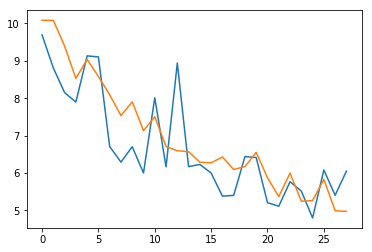

In [31]:
#create model
model_cnn_v2 = Sequential()

model_cnn_v2.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(96,96,1)))
model_cnn_v2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_cnn_v2.add(Flatten())
model_cnn_v2.add(Dense(30, activation='linear'))

model_cnn_v2.compile(optimizer=optimizers.Adam(0.002), 
              loss = 'mean_squared_error',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

history = model_cnn_v2.fit(train_features_reshaped, 
                           train_labels, 
                           epochs = 30,
                           verbose= 1, 
                           batch_size= 100, 
                           validation_data=(validation_features_reshaped, validation_labels),
                           callbacks=[es])

plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['loss'][2:])

In [32]:
validation_predicted_labels_cnn = model_cnn.predict(validation_features_reshaped)
validation_predicted_labels_new = model_cnn_v2.predict(validation_features_reshaped)

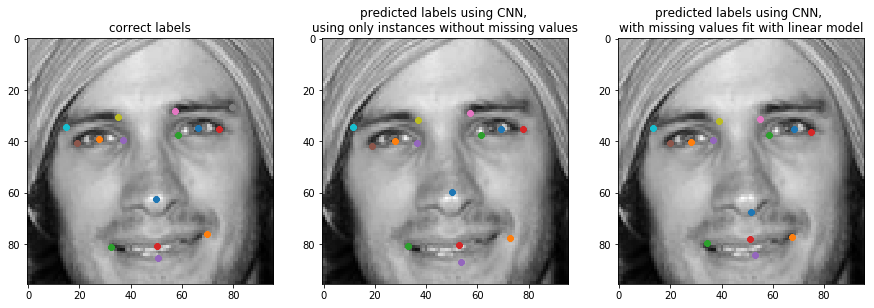

In [39]:
fig, ax = plt.subplots(1,3, figsize = (15, 10))

image_no = 30

ax[0].imshow(validation_features[image_no].reshape((96,96)), cmap='gray')
ax[0].plot([validation_labels[image_no][0::2]],[validation_labels[image_no][1::2]], marker='8')
ax[0].title.set_text('correct labels')
ax[1].imshow(validation_features[image_no].reshape((96,96)), cmap='gray')
ax[1].plot([validation_predicted_labels_cnn[image_no][0::2]],
           [validation_predicted_labels_cnn[image_no][1::2]], marker='8')
ax[1].title.set_text('predicted labels using CNN, \nusing only instances without missing values')
ax[2].imshow(validation_features[image_no].reshape((96,96)), cmap='gray')
ax[2].plot([validation_predicted_labels_new[image_no][0::2]],
           [validation_predicted_labels_new[image_no][1::2]], marker='8')
ax[2].title.set_text('predicted labels using CNN, \nwith missing values fit with linear model')


Take a look at test data

In [ ]:
predicted_labels_cnn = model_cnn.predict(test_images)
predicted_labels_new = model_cnn_v2.predict(test_images)

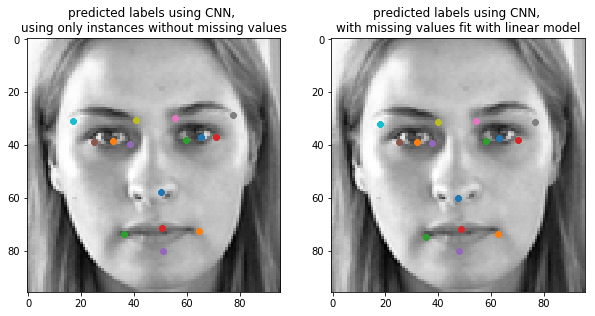

In [40]:
test_images, _ = process_data(test)
test_images = test_images.reshape(test_images.shape[0],96,96,1)

image_no = 20
fig, ax = plt.subplots(1,2, figsize = (10, 5))
ax[0].imshow(test_images[image_no].reshape((96,96)), cmap='gray')
ax[0].plot([predicted_labels_cnn[image_no][0::2]],
           [predicted_labels_cnn[image_no][1::2]], marker='8')
ax[0].title.set_text('predicted labels using CNN, \nusing only instances without missing values')
ax[1].imshow(test_images[image_no].reshape((96,96)), cmap='gray')
ax[1].plot([predicted_labels_new[image_no][0::2]],
           [predicted_labels_new[image_no][1::2]], marker='8')
ax[1].title.set_text('predicted labels using CNN, \nwith missing values fit with linear model')